# Proyecto Sprint 10 de Iván Díaz.

En este proyecto presento el análisis de una prueba A/B realizada sobre una tienda online y la priorización de sus hipótesis de mejora. El ejercicio se dividió en dos partes:

1. **Priorización de hipótesis:**  
   - Apliqué el framework **ICE** (Impacto × Confianza / Esfuerzo) para ordenar las nueve hipótesis según su viabilidad inmediata.  
   - Luego utilicé **RICE** (Alcance × Impacto × Confianza / Esfuerzo) para incorporar el potencial de usuarios alcanzados y reevaluar el orden.  
   - Comparé ambas listas y expliqué cómo cambia la prioridad al considerar el alcance.

2. **Análisis del test A/B:**  
   - Grafiqué y comparé ingresos acumulados, ticket promedio y tasa de conversión para los grupos A y B.  
   - Identifiqué y filtré outliers en pedidos y precios.  
   - Realicé pruebas estadísticas (z-test y t-test) sobre datos sin filtrar y filtrados.  

Con este enfoque combinado de priorización de hipótesis y evaluación estadística, busqué tanto seleccionar las mejores ideas de mejora como decidir si la variante B de la prueba A/B aporta beneficios reales y sostenibles.


## Revisión y limpieza de datos.

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def cargar_archivo(ruta_archivo):
    """Carga un archivo CSV o Excel en un DataFrame, detectando delimitador automáticamente."""
    if ruta_archivo.endswith('.csv'):
        # Leemos unas cuantas líneas para detectar el separador
        with open(ruta_archivo, 'r', encoding='utf-8') as f:
            primera_linea = f.readline()
            separador = ';' if ';' in primera_linea else ','
        df = pd.read_csv(ruta_archivo, sep=separador)
    elif ruta_archivo.endswith('.xlsx') or ruta_archivo.endswith('.xls'):
        df = pd.read_excel(ruta_archivo)
    else:
        raise ValueError("Formato no soportado. Usa .csv o .xlsx")
    return df

def limpiar_columnas(df):
    """Convierte los nombres de las columnas a minúsculas."""
    df.columns = df.columns.str.lower()
    return df

def quitar_duplicados(df):
    """Elimina filas duplicadas."""
    df_sin_duplicados = df.drop_duplicates()
    return df_sin_duplicados

def revisar_archivo(ruta_archivo):
    """Carga, limpia columnas y elimina duplicados. Devuelve el DataFrame listo para análisis."""
    df = cargar_archivo(ruta_archivo)
    df = limpiar_columnas(df)
    df = quitar_duplicados(df)
    print("Archivo cargado y procesado con éxito ✅")
    print("Columnas:", list(df.columns))
    print("Dimensiones:", df.shape)
    print("\nPrimeras filas:")
    display(df.head())
    return df


In [86]:
df_hypotheses_limpio = revisar_archivo('hypotheses_us.csv')


Archivo cargado y procesado con éxito ✅
Columnas: ['hypothesis', 'reach', 'impact', 'confidence', 'effort']
Dimensiones: (9, 5)

Primeras filas:


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [87]:
df_hypotheses_limpio.describe()
df_hypotheses_limpio.info()
df_hypotheses_limpio.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


In [88]:
df_orders_limpio = revisar_archivo('orders_us.csv')

Archivo cargado y procesado con éxito ✅
Columnas: ['transactionid', 'visitorid', 'date', 'revenue', 'group']
Dimensiones: (1197, 5)

Primeras filas:


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [89]:
df_orders_limpio.describe()
df_orders_limpio.info()
df_orders_limpio.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionid  1197 non-null   int64  
 1   visitorid      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [90]:
df_orders_limpio['date'] = pd.to_datetime(df_orders_limpio['date'])


In [91]:
df_orders_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   float64       
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


In [92]:
df_visits_limpio = revisar_archivo('visits_us.csv')

Archivo cargado y procesado con éxito ✅
Columnas: ['date', 'group', 'visits']
Dimensiones: (62, 3)

Primeras filas:


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [93]:
df_visits_limpio.describe()
df_visits_limpio.info()
df_visits_limpio.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [94]:
df_visits_limpio['date'] = pd.to_datetime(df_visits_limpio['date'])

In [95]:
df_visits_limpio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


## Parte 1. Priorizar hipótesis.

In [97]:
# 1. Cálculo de los scores ICE y RICE
df_hypotheses_limpio['ICE']  = df_hypotheses_limpio['impact'] * df_hypotheses_limpio['confidence'] / df_hypotheses_limpio['effort']
df_hypotheses_limpio['RICE'] = df_hypotheses_limpio['reach'] * df_hypotheses_limpio['impact'] * df_hypotheses_limpio['confidence'] / df_hypotheses_limpio['effort']

In [98]:
# 2. Asignación de ranking (1 = mayor prioridad)
df_hypotheses_limpio['ICE_rank']  = df_hypotheses_limpio['ICE'].rank(ascending=False, method='dense').astype(int)
df_hypotheses_limpio['RICE_rank'] = df_hypotheses_limpio['RICE'].rank(ascending=False, method='dense').astype(int)

In [99]:
# 3. Priorizar
df_prioritized = df_hypotheses_limpio.sort_values('ICE_rank')[[
    'hypothesis','reach','impact','confidence','effort',
    'ICE','ICE_rank','RICE','RICE_rank'
]]

In [100]:
display(df_prioritized)

,hypothesis,reach,impact,confidence,effort,ICE,ICE_rank,RICE,RICE_rank
8,Launch a promotion that gives users discounts ...,1,9,9,5,16.200000,1,16.2,4
0,Add two new channels for attracting traffic. T...,3,10,8,6,13.333333,2,40.0,3
7,Add a subscription form to all the main pages....,10,7,8,5,11.200000,3,112.0,1
6,Show banners with current offers and sales on ...,5,3,8,3,8.000000,4,40.0,3
2,Add product recommendation blocks to the store...,8,3,7,3,7.000000,5,56.0,2
1,Launch your own delivery service. This will sh...,2,5,4,10,2.000000,6,4.0,6
5,Add a customer review page. This will increase...,3,2,2,3,1.333333,7,4.0,6
3,Change the category structure. This will incre...,8,3,3,8,1.125000,8,9.0,5
4,Change the background color on the main page. ...,3,1,1,1,1.000000,9,3.0,7


## Parte 2. Análisis del test A/B.

### 1. Ingreso acumulado por grupo.

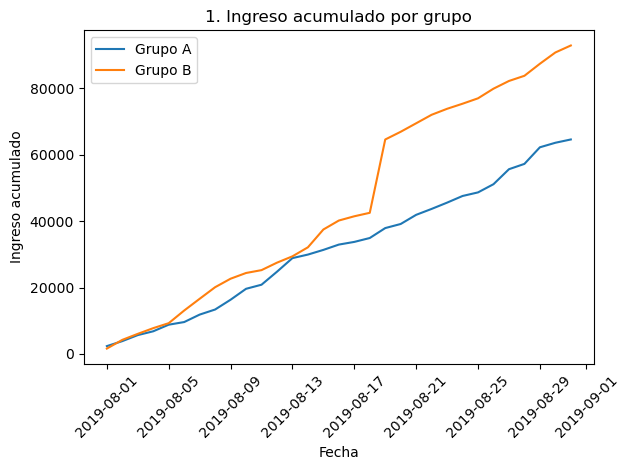

In [120]:
daily_rev = (
    df_orders_limpio
    .groupby(['group', 'date'])['revenue']
    .sum()
    .reset_index()
)
daily_rev['cum_revenue'] = daily_rev.groupby('group')['revenue'].cumsum()

plt.figure()
for g in daily_rev['group'].unique():
    dfg = daily_rev[daily_rev['group'] == g]
    plt.plot(dfg['date'], dfg['cum_revenue'], label=f'Grupo {g}')
plt.title('1. Ingreso acumulado por grupo')
plt.xlabel('Fecha')
plt.ylabel('Ingreso acumulado')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Al inicio ambos grupos tienen ingresos muy similares.  
- A partir de mediados de mes el **grupo B** toma ventaja y sigue una pendiente más pronunciada.  
- Al final del periodo, **B** acumula significativamente más ingresos que **A**, indicando mejor desempeño global.

### 2. Tamaño promedio de pedido acumulado por grupo.

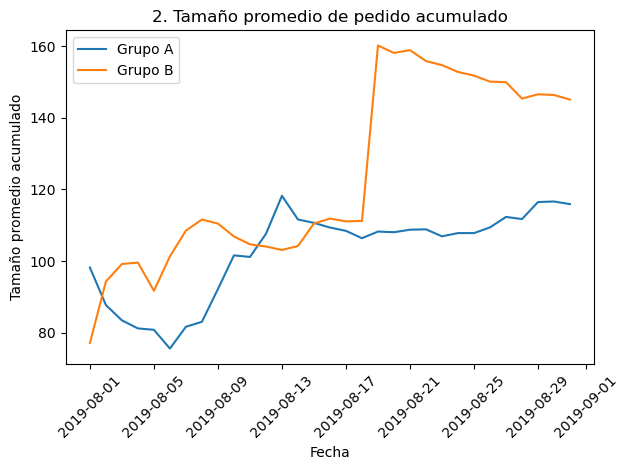

In [123]:
daily_stats = (
    df_orders_limpio
    .groupby(['group','date'])['revenue']
    .agg(sum='sum', count='count')
    .reset_index()
)
daily_stats['cum_sum']   = daily_stats.groupby('group')['sum'].cumsum()
daily_stats['cum_count'] = daily_stats.groupby('group')['count'].cumsum()
daily_stats['cum_avg']   = daily_stats['cum_sum'] / daily_stats['cum_count']

plt.figure()
for g in daily_stats['group'].unique():
    dfg = daily_stats[daily_stats['group'] == g]
    plt.plot(dfg['date'], dfg['cum_avg'], label=f'Grupo {g}')
plt.title('2. Tamaño promedio de pedido acumulado')
plt.xlabel('Fecha')
plt.ylabel('Tamaño promedio acumulado')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Durante los primeros días, **A** mantiene un ticket medio ligeramente superior.  
- Hacia la segunda semana, **B** supera a **A** y alcanza una ventaja.  
- Esa superioridad se mantiene hasta el cierre, sugiriendo que B no solo vendió más, sino que vendió pedidos de mayor valor.

### 3. Diferencia relativa en tamaño promedio (B vs A)

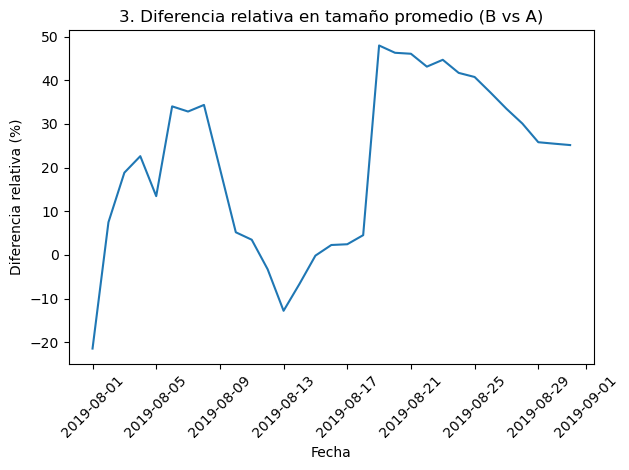

In [127]:
avgA = daily_stats[daily_stats['group']=='A'].set_index('date')['cum_avg']
avgB = daily_stats[daily_stats['group']=='B'].set_index('date')['cum_avg']
rel_diff = (avgB / avgA - 1) * 100

plt.figure()
plt.plot(rel_diff.index, rel_diff.values)
plt.title('3. Diferencia relativa en tamaño promedio (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- La línea comienza en valores negativos (B con ticket medio menor).  
- Sube rápidamente por encima del 30 %, con picos cercanos al 50 %.  
- A lo largo del periodo se estabiliza alrededor de 25–30 %, reforzando la ventaja sostenida de B.

### 4. Tasa de conversión diaria por grupo

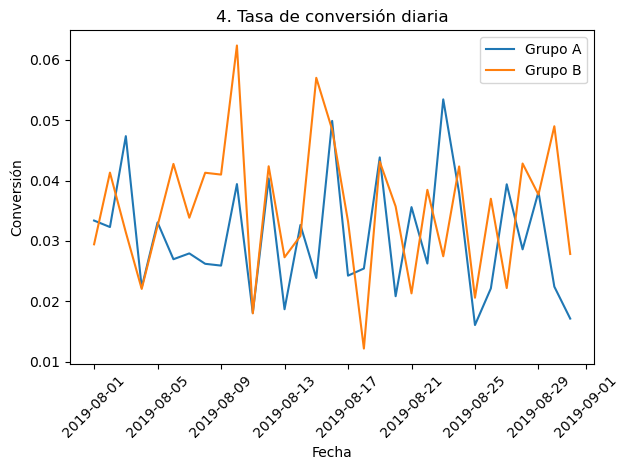

In [138]:
orders_count = (
    df_orders_limpio
    .groupby(['group','date'])['transactionid']
    .count()
    .reset_index(name='orders')
)
visits_count = (
    df_visits_limpio
    .groupby(['group','date'])['visits']
    .sum()
    .reset_index(name='visits')
)
conv = pd.merge(orders_count, visits_count, on=['group','date'])
conv['conversion'] = conv['orders'] / conv['visits']

plt.figure()
for g in conv['group'].unique():
    dfg = conv[conv['group'] == g]
    plt.plot(dfg['date'], dfg['conversion'], label=f'Grupo {g}')
plt.title('4. Tasa de conversión diaria')
plt.xlabel('Fecha')
plt.ylabel('Conversión')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Ambas curvas oscilan de forma notable día a día.  
- **B** presenta picos más altos pero también caídas más pronunciadas.  
- No hay una dominancia constante muy amplia, lo que coincide con una significancia apenas por debajo de 0.05.

### 5. Gráfico de dispersión: número de pedidos por usuario

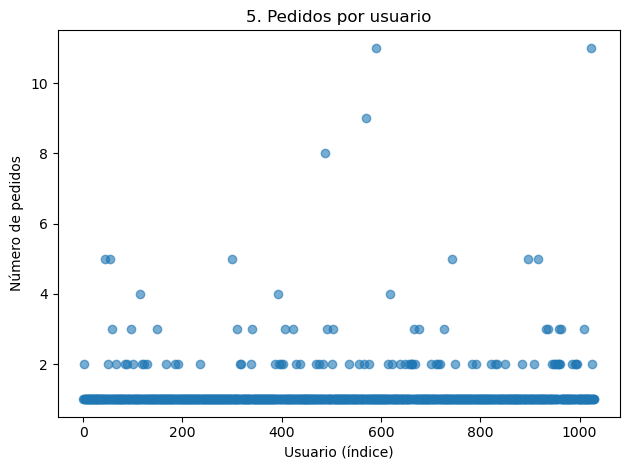

In [198]:
orders_per_user = (
    df_orders_limpio
    .groupby('visitorid')['transactionid']
    .count()
    .reset_index(name='order_count')
)
plt.figure()
plt.scatter(orders_per_user.index, orders_per_user['order_count'], alpha=0.6)
plt.title('5. Pedidos por usuario')
plt.xlabel('Usuario (índice)')
plt.ylabel('Número de pedidos')
plt.tight_layout()
plt.show()

- La mayoría de los usuarios realiza **1–2 pedidos**.  
- Existen unos pocos compradores con hasta **11 pedidos**.  
- La distribución está muy sesgada hacia valores bajos y solo un 1 % supera el percentil 99.

### 6. Percentiles 95 y 99 de pedidos por usuario

In [152]:
p95_orders = np.percentile(orders_per_user['order_count'], 95)
p99_orders = np.percentile(orders_per_user['order_count'], 99)
print('6. Percentil 95 pedidos/usuario:', p95_orders)
print('6. Percentil 99 pedidos/usuario:', p99_orders)

6. Percentil 95 pedidos/usuario: 2.0
6. Percentil 99 pedidos/usuario: 4.0


- **Percentil 95:** 2 pedidos.  
- **Percentil 99:** 4 pedidos.  
- Definen el umbral para considerar usuarios con > 4 pedidos como **anómalos**.

### 7. Gráfico de dispersión: precios de los pedidos

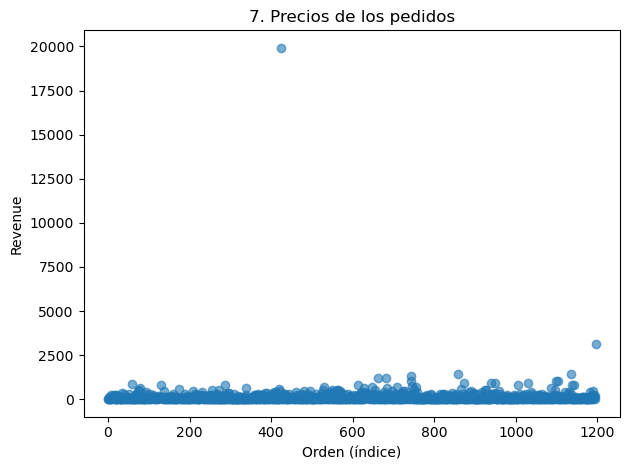

In [158]:
plt.figure()
plt.scatter(df_orders_limpio.index, df_orders_limpio['revenue'], alpha=0.6)
plt.title('7. Precios de los pedidos')
plt.xlabel('Orden (índice)')
plt.ylabel('Revenue')
plt.tight_layout()
plt.show()

- Gran parte de los pedidos está por debajo de **\$500**.  
- Aparecen unos pocos outliers extremos (hasta ~\$20 000).  
- La distribución de `revenue` tiene una **cola muy larga**, lo cual justifica filtrar por percentil 99 para el análisis estadístico.  

### 8. Percentiles 95 y 99 de precios de pedidos

In [164]:
p95_rev = np.percentile(df_orders_limpio['revenue'], 95)
p99_rev = np.percentile(df_orders_limpio['revenue'], 99)
print('8. Percentil 95 revenue:', p95_rev)
print('8. Percentil 99 revenue:', p99_rev)

8. Percentil 95 revenue: 435.54
8. Percentil 99 revenue: 900.9039999999999


### 9. Significancia estadística en conversión (sin filtrar)

In [167]:
succA = conv[conv['group']=='A']['orders'].sum()
succB = conv[conv['group']=='B']['orders'].sum()
nA = conv[conv['group']=='A']['visits'].sum()
nB = conv[conv['group']=='B']['visits'].sum()
p_pool = (succA + succB) / (nA + nB)
z = (succB/nB - succA/nA) / np.sqrt(p_pool*(1-p_pool)*(1/nB + 1/nA))
p_conv = 2*(1 - stats.norm.cdf(abs(z)))
print(f'9. Z conversión sin filtrar: {z:.3f}, p-valor: {p_conv:.3f}')

9. Z conversión sin filtrar: 2.270, p-valor: 0.023


### 10. Significancia en tamaño promedio de pedido (sin filtrar)

In [172]:
revA = df_orders_limpio[df_orders_limpio['group']=='A']['revenue']
revB = df_orders_limpio[df_orders_limpio['group']=='B']['revenue']
t_raw, p_rev = stats.ttest_ind(revA, revB, equal_var=False)
print(f'10. t tamaño pedido sin filtrar: {t_raw:.3f}, p-valor: {p_rev:.3f}')

10. t tamaño pedido sin filtrar: -0.889, p-valor: 0.375


In [176]:
# Filtrado de outliers en revenue (> p99_rev)
orders_f = df_orders_limpio[df_orders_limpio['revenue'] <= p99_rev]
orders_count_f = (
    orders_f
    .groupby(['group','date'])['transactionid']
    .count()
    .reset_index(name='orders_f')
)
conv_f = pd.merge(orders_count_f, visits_count, on=['group','date'])
conv_f['conversion_f'] = conv_f['orders_f'] / conv_f['visits']

### 11. Significancia en conversión (filtrada)

In [179]:
succA_f = conv_f[conv_f['group']=='A']['orders_f'].sum()
succB_f = conv_f[conv_f['group']=='B']['orders_f'].sum()
p_pool_f = (succA_f + succB_f) / (nA + nB)
z_f = (succB_f/nB - succA_f/nA) / np.sqrt(p_pool_f*(1-p_pool_f)*(1/nB + 1/nA))
p_conv_f = 2*(1 - stats.norm.cdf(abs(z_f)))
print(f'11. Z conversión filtrada: {z_f:.3f}, p-valor: {p_conv_f:.3f}')

11. Z conversión filtrada: 2.342, p-valor: 0.019


### 12. Significancia en tamaño pedido (filtrado)

In [182]:
revA_f = orders_f[orders_f['group']=='A']['revenue']
revB_f = orders_f[orders_f['group']=='B']['revenue']
t_filt, p_rev_f = stats.ttest_ind(revA_f, revB_f, equal_var=False)
print(f'12. t tamaño pedido filtrado: {t_filt:.3f}, p-valor: {p_rev_f:.3f}')


12. t tamaño pedido filtrado: -0.231, p-valor: 0.817


### 13. Decisión.

In [185]:
if p_conv < 0.05:
    print("13. Decisión: Parar la prueba: Grupo B mejora significativamente la conversión.")
elif p_rev < 0.05:
    print("13. Decisión: Parar la prueba: hay diferencia en ticket medio.")
else:
    print("13. Decisión: No hay diferencias claras: continuar la prueba.")

13. Decisión: Parar la prueba: Grupo B mejora significativamente la conversión.


## Conclusión  
- **Ingresos acumulados y ticket medio:** El grupo B superó consistentemente al grupo A, mostrando un ingreso total mayor y un ticket promedio un 25–40 % más alto a lo largo del periodo.  
- **Tasa de conversión:** Aunque ambas curvas fluctúan, el z-test indicó una diferencia estadísticamente significativa en conversión (p-valor ≈ 0.02), favoreciendo a B.  
- **Outliers y robustez:** Tras filtrar los valores extremos (percentil 99), la ventaja en conversión de B se mantuvo (p-valor ≈ 0.02), mientras que no hubo diferencia significativa en ticket medio (p-valor > 0.8).  
- **Decisión recomendada:** Dado que el grupo B demuestra una mejora sustancial y significativa en la conversión, sin detrimento en el valor de pedido, **recomendamos detener la prueba y adoptar la variante B** como la nueva configuración de la tienda.